In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')

from core.Lie import LieLayer

Using TensorFlow backend.


This example demonstrates application of tensor Lie transform to identification and dynamics modeling for well known Lotka–Volterra model: https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations

The predator–prey population is described by system of nonlinear differential equations with right-hand side

In [3]:
def f(t, X, a=-2, b=-1, d=-1, g=-1):
    x = X[0]
    y = X[1]
    return np.array([ a*x - b*x*y, d*x*y - g*y])

The equations describe nonlinear oscillation with fixed (stationary) point. To solve the differential equation we will use simple Runge–Kutta method of 4th order

In [4]:
def integrate(X0, dt, N, a=-2, b=-1, d=-1, g=-1):
    ans = np.empty((N, 2))
    t = 0
    X = X0
    for i in xrange(N):
        k1 = f(t, X)
        k2 = f(t+dt/2.0, X+dt*k1/2.0)
        k3 = f(t+dt/2.0, X+dt*k2/2.0)
        k4 = f(t+dt, X + dt*k3)

        X = X + dt*(k1+2*k2+2*k3+k4)/6.0  
        ans[i] = X
        t += dt

    # normalization to the fixed point:
    ans -= np.array([g/d, a/b])
    return ans

So we can simply integrate equations with different initial points and generate train and test data. Note that train and test data are produced by the same dynamical systems but starting from different points. The key idea of the givven example is demonstrate possibility to generalize knowledge about whole system using only the information about single sample.

In [5]:
N = 465
dt = 0.01

X_train = integrate(np.array([1.5, 2.5]), dt, N)
X_test_outer  = integrate(np.array([1.8, 2.8]), dt, N)
X_test_inner  = integrate(np.array([1.1, 2.1]), dt, N)
X_test_fixed  = integrate(np.array([1.0, 2.0]), dt, N)

Each X vector contains now predator–prey population sizes. One can visualize dynamics of the system either in phase space (predator-–prey coordinates) or in time

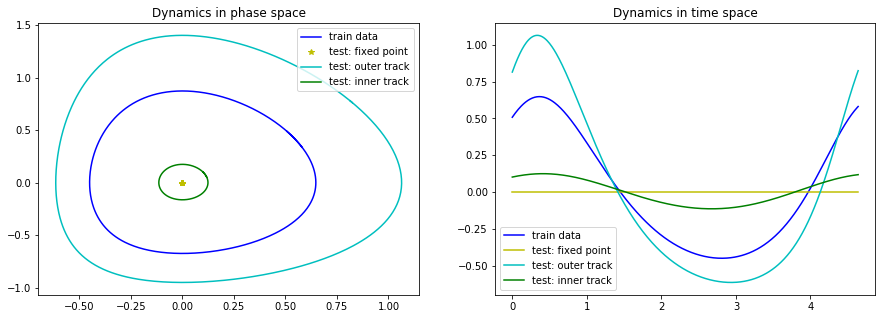

In [12]:
f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(X_train[:,0], X_train[:,1], 'b-', label='train data')
ax[0].plot(X_test_fixed[:,0], X_test_fixed[:,1], 'y*', label='test: fixed point')
ax[0].plot(X_test_outer[:,0], X_test_outer[:,1], 'c-', label='test: outer track')
ax[0].plot(X_test_inner[:,0], X_test_inner[:,1], 'g-', label='test: inner track')

time = np.arange(N)*dt
        
ax[1].plot(time, X_train[:,0], 'b-', label='train data')
ax[1].plot(time, X_test_fixed[:,0], 'y-', label='test: fixed point')
ax[1].plot(time, X_test_outer[:,0], 'c-', label='test: outer track')
ax[1].plot(time, X_test_inner[:,0], 'g-', label='test: inner track')

for k in [0,1]:
    handles, labels = ax[k].get_legend_handles_labels()
    ax[k].legend(handles, labels)

ax[0].set_title('Dynamics in phase space')
ax[1].set_title('Dynamics in time space')

plt.show()

As a train data we will use only blue track. The neural networks will be trained on it and then asked to predict dynamics in different parameter spaces. Cyan tracks corresponds to hire order of nonlinearity, green one is almost linear oscillation, and yellow point is stationary point where population sizes are constant in time.

We will use 3 different architectures of neural networks for this purpose: Lie transform based network, Multilayer perceptron and LSTM. We will predict dynamics of state vector X[i] –> X[i+1], so we need 2 dimension (both predator and pray) for input and output.

In [36]:
def createLieNet(inputDim=2, outputDim=2, order=2):
    model = Sequential()
    model.add(LieLayer(output_dim = outputDim, order=order,
                      input_shape = (inputDim,)))
    opt = keras.optimizers.Adamax(lr=0.02, beta_1=0.99,
                                  beta_2=0.99999, epsilon=1e-1, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model


def createMLP(inputDim, outputDim):
    model = Sequential()
    model.add(Dense(4, input_dim=inputDim, init='uniform', activation='sigmoid'))
    model.add(Dense(4, init='uniform', activation='sigmoid'))
    model.add(Dense(outputDim, init='uniform', activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    return model


def createLSTM(inputDim, outputDim):
    model = Sequential()
    model.add(LSTM(10, input_dim=inputDim, input_length=1))
    model.add(Dense(outputDim, init='uniform', activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model


lie = createLieNet(2,2)
mlp = createMLP(2,2)
lstm = createLSTM(2,2)

num_epoch = 2000
lie.fit(X_train[:-1], X_train[1:], nb_epoch=num_epoch, batch_size=50, verbose=0)
print('Lie transform is built')
mlp.fit(X_train[1:], X_train[1:], nb_epoch=num_epoch, batch_size=50, verbose=0)
print('MLP is built')
lstm.fit(X_train[1:].reshape((-1, 1, X_train.shape[1])), X_train[1:], nb_epoch=num_epoch, batch_size=50, verbose=0)
print('LSTM is built')

Lie transform is built
MLP is built
LSTM is built


To estimate dynamics in unknown space of initial points we will iteratively predict state vector starting from initial points

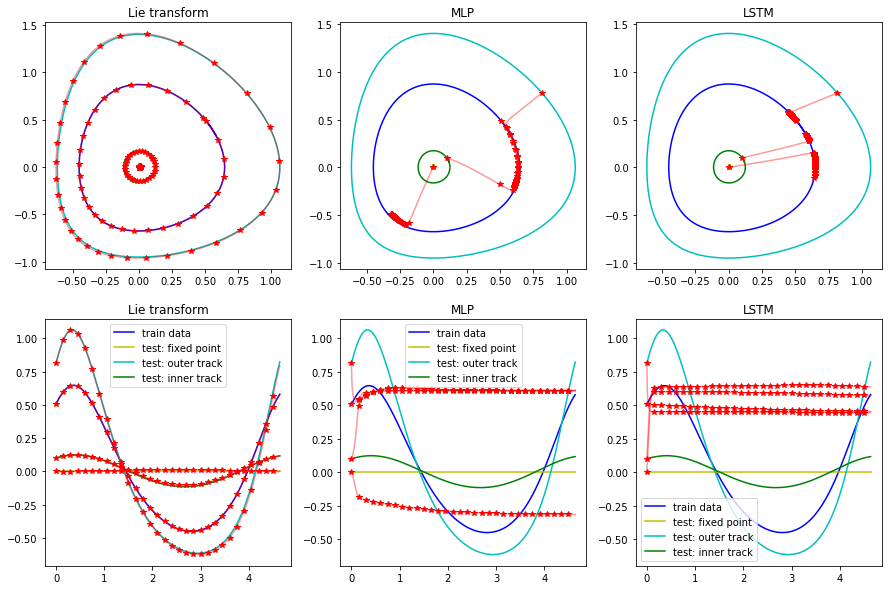

In [38]:
def iterative_predict(model, X0, N, reshape = False):
    ans = np.empty((N, 2))
    X = X0.reshape(-1,2)
    for i in xrange(N):
        if reshape:
            X = model.predict(X.reshape(1,1,2))
        else:
            X = model.predict(X)
        ans[i] = X
    return np.vstack((X0, ans[:-1]))


# draw true train and test data
f, ax = plt.subplots(2,3,figsize=(15,10))
for i in xrange(3):
    ax[0, i].plot(X_train[:,0], X_train[:,1], 'b-', label='train data')
    ax[0, i].plot(X_test_fixed[:,0], X_test_fixed[:,1], 'y*', label='test: fixed point')
    ax[0, i].plot(X_test_outer[:,0], X_test_outer[:,1], 'c-', label='test: outer track')
    ax[0, i].plot(X_test_inner[:,0], X_test_inner[:,1], 'g-', label='test: inner track')
      
    ax[1, i].plot(time, X_train[:,0], 'b-', label='train data')
    ax[1, i].plot(time, X_test_fixed[:,0], 'y-', label='test: fixed point')
    ax[1, i].plot(time, X_test_outer[:,0], 'c-', label='test: outer track')
    ax[1, i].plot(time, X_test_inner[:,0], 'g-', label='test: inner track')

for k in xrange(3):
    handles, labels = ax[1, k].get_legend_handles_labels()
    ax[1, k].legend(handles, labels)

for i in xrange(2):
    ax[i,0].set_title('Lie transform')
    ax[i,1].set_title('MLP')
    ax[i,2].set_title('LSTM')


# then predict via different neural networks
reshapes = [False, False, True]
for i, model in enumerate([lie, mlp, lstm]):
    X_train_predict      = iterative_predict(model, X_train[0], N, reshape = reshapes[i])
    X_test_outer_predict = iterative_predict(model, X_test_outer[0], N, reshape  = reshapes[i])
    X_test_inner_predict = iterative_predict(model, X_test_inner[0], N, reshape  = reshapes[i])
    X_test_fixed_predict = iterative_predict(model, X_test_fixed[0], N, reshape  = reshapes[i])
    
    for X_predict in [X_train_predict, X_test_outer_predict, X_test_inner_predict, X_test_fixed_predict]:
        ax[0, i].plot(X_predict[::15,0], X_predict[::15,1], 'r*')
        ax[0, i].plot(X_predict[:,0], X_predict[:,1], 'r-', alpha=0.4)

        ax[1, i].plot(time[::15], X_predict[::15,0], 'r*')
        ax[1, i].plot(time, X_predict[:,0], 'r-', alpha=0.4)

    
    
plt.show()

As one can see Lie transform generalizes nonlinear dynamics and can predict behavior of the system. Both LSTM and MLP tend to memorize single solution and attract all other points to the given train data.